In [17]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# LOAD DATA 
file_pattern = os.path.join("tennis_wta-master", "wta_matches_*.csv")
all_files = glob.glob(file_pattern)
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

df['tourney_date'] = pd.to_datetime(df['tourney_date'].astype(str), format='%Y%m%d', errors='coerce')
df = df.dropna(subset=['tourney_date']).sort_values('tourney_date').reset_index(drop=True)

print(f"Loaded {len(df)} matches from {df['tourney_date'].min()} to {df['tourney_date'].max()}")

# PRE-MATCH FEATURES
def calculate_historical_stats_fast(df, min_days_gap=7):
    """
    Faster calculation of historical statistics using vectorized operations where possible
    """
    results = []
    
    all_players = set(df['winner_name'].unique()) | set(df['loser_name'].unique())
    
    for idx, match in df.iterrows():
        current_date = match['tourney_date']
        winner_name = match['winner_name']
        loser_name = match['loser_name']
        
        cutoff_date = current_date - timedelta(days=min_days_gap)
        
        historical_data = df[
            (df['tourney_date'] < cutoff_date) & 
            ((df['winner_name'].isin([winner_name, loser_name])) | 
             (df['loser_name'].isin([winner_name, loser_name])))
        ]
        
        if len(historical_data) == 0:
            continue
        
        winner_wins = len(historical_data[historical_data['winner_name'] == winner_name])
        winner_losses = len(historical_data[historical_data['loser_name'] == winner_name])
        winner_total = winner_wins + winner_losses
        winner_win_rate = winner_wins / winner_total if winner_total > 0 else 0
        
        loser_wins = len(historical_data[historical_data['winner_name'] == loser_name])
        loser_losses = len(historical_data[historical_data['loser_name'] == loser_name])
        loser_total = loser_wins + loser_losses
        loser_win_rate = loser_wins / loser_total if loser_total > 0 else 0
        
        winner_recent_rank = 1000  # Default
        loser_recent_rank = 1000
        
        winner_matches = historical_data[
            (historical_data['winner_name'] == winner_name) | 
            (historical_data['loser_name'] == winner_name)
        ]
        if len(winner_matches) > 0:
            recent_match = winner_matches.iloc[-1]  # Most recent
            if recent_match['winner_name'] == winner_name:
                winner_recent_rank = recent_match.get('winner_rank', 1000) or 1000
            else:
                winner_recent_rank = recent_match.get('loser_rank', 1000) or 1000
        
        loser_matches = historical_data[
            (historical_data['winner_name'] == loser_name) | 
            (historical_data['loser_name'] == loser_name)
        ]
        if len(loser_matches) > 0:
            recent_match = loser_matches.iloc[-1]  # Most recent
            if recent_match['winner_name'] == loser_name:
                loser_recent_rank = recent_match.get('winner_rank', 1000) or 1000
            else:
                loser_recent_rank = recent_match.get('loser_rank', 1000) or 1000
        
        h2h_winner_wins = len(historical_data[
            (historical_data['winner_name'] == winner_name) & 
            (historical_data['loser_name'] == loser_name)
        ])
        h2h_loser_wins = len(historical_data[
            (historical_data['winner_name'] == loser_name) & 
            (historical_data['loser_name'] == winner_name)
        ])
        h2h_total = h2h_winner_wins + h2h_loser_wins
        h2h_winner_rate = h2h_winner_wins / h2h_total if h2h_total > 0 else 0.5
        
        winner_days_since = 30 if len(winner_matches) == 0 else min((current_date - winner_matches.iloc[-1]['tourney_date']).days, 365)
        loser_days_since = 30 if len(loser_matches) == 0 else min((current_date - loser_matches.iloc[-1]['tourney_date']).days, 365)
        
        results.append({
            'match_index': idx,
            'winner_win_rate': winner_win_rate,
            'loser_win_rate': loser_win_rate,
            'winner_total_matches': winner_total,
            'loser_total_matches': loser_total,
            'winner_recent_rank': winner_recent_rank,
            'loser_recent_rank': loser_recent_rank,
            'h2h_winner_rate': h2h_winner_rate,
            'h2h_total_matches': h2h_total,
            'winner_days_since_last': winner_days_since,
            'loser_days_since_last': loser_days_since
        })
        
        if idx % 1000 == 0:
            print(f"Processed {idx}/{len(df)} matches...")
    
    return pd.DataFrame(results)

print("Calculating historical features...")
historical_features = calculate_historical_stats_fast(df, min_days_gap=7)

df_with_features = df.loc[historical_features['match_index']].copy().reset_index(drop=True)
historical_features = historical_features.reset_index(drop=True)

for col in historical_features.columns:
    if col != 'match_index':
        df_with_features[col] = historical_features[col]

df_filtered = df_with_features[
    (df_with_features['winner_total_matches'] >= 5) & 
    (df_with_features['loser_total_matches'] >= 5)
].copy()

print(f"After filtering: {len(df_filtered)} matches with sufficient historical data")

if len(df_filtered) < 100:
    print("Not enough matches with historical data. Reducing requirements...")
    df_filtered = df_with_features[
        (df_with_features['winner_total_matches'] >= 2) & 
        (df_with_features['loser_total_matches'] >= 2)
    ].copy()
    print(f"With reduced requirements: {len(df_filtered)} matches")

# MATCH CONTEXT FEATURES
if 'surface' in df_filtered.columns:
    df_filtered['surface_code'] = pd.Categorical(df_filtered['surface']).codes
else:
    df_filtered['surface_code'] = 0

df_filtered['month'] = df_filtered['tourney_date'].dt.month
df_filtered['year'] = df_filtered['tourney_date'].dt.year

for col in ['winner_age', 'loser_age']:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce').fillna(25)
    else:
        df_filtered[col] = 25

for col, hand_col in [('winner_hand', 'winner_hand_code'), ('loser_hand', 'loser_hand_code')]:
    if col in df_filtered.columns:
        df_filtered[hand_col] = pd.Categorical(df_filtered[col]).codes
    else:
        df_filtered[hand_col] = 0

# SPLIT TIME
print("Splitting data by time...")
# split_date = df_filtered['tourney_date'].quantile(0.8)
# print(f"Split date: {split_date}")

# train_matches = df_filtered[df_filtered['tourney_date'] < split_date].copy()
# test_matches = df_filtered[df_filtered['tourney_date'] >= split_date].copy()

split_year = 2024
train_matches = df_filtered[df_filtered['tourney_date'].dt.year < split_year].copy()
test_matches = df_filtered[df_filtered['tourney_date'].dt.year == split_year].copy()

print(f"Train matches: {len(train_matches)}")
print(f"Test matches: {len(test_matches)}")

# CREATE BALANCED DATASET W/ SPLIT
def create_balanced_from_matches(matches_df):
    """Create balanced dataset from a set of matches"""
    # Scenario 1: Winner as Player1 (target = 1)
    scenario1 = matches_df.copy()
    scenario1['player1_win_rate'] = matches_df['winner_win_rate']
    scenario1['player2_win_rate'] = matches_df['loser_win_rate'] 
    scenario1['player1_matches'] = matches_df['winner_total_matches']
    scenario1['player2_matches'] = matches_df['loser_total_matches']
    scenario1['player1_rank'] = matches_df['winner_recent_rank']
    scenario1['player2_rank'] = matches_df['loser_recent_rank']
    scenario1['player1_age'] = matches_df['winner_age']
    scenario1['player2_age'] = matches_df['loser_age']
    scenario1['player1_hand'] = matches_df['winner_hand_code']
    scenario1['player2_hand'] = matches_df['loser_hand_code']
    scenario1['player1_days_rest'] = matches_df['winner_days_since_last']
    scenario1['player2_days_rest'] = matches_df['loser_days_since_last']
    scenario1['h2h_p1_advantage'] = matches_df['h2h_winner_rate']
    scenario1['target'] = 1
    
    # Scenario 2: Loser as Player1 (target = 0)  
    scenario2 = matches_df.copy()
    scenario2['player1_win_rate'] = matches_df['loser_win_rate']
    scenario2['player2_win_rate'] = matches_df['winner_win_rate']
    scenario2['player1_matches'] = matches_df['loser_total_matches'] 
    scenario2['player2_matches'] = matches_df['winner_total_matches']
    scenario2['player1_rank'] = matches_df['loser_recent_rank']
    scenario2['player2_rank'] = matches_df['winner_recent_rank']
    scenario2['player1_age'] = matches_df['loser_age']
    scenario2['player2_age'] = matches_df['winner_age']
    scenario2['player1_hand'] = matches_df['loser_hand_code']
    scenario2['player2_hand'] = matches_df['winner_hand_code']
    scenario2['player1_days_rest'] = matches_df['loser_days_since_last']
    scenario2['player2_days_rest'] = matches_df['winner_days_since_last']
    scenario2['h2h_p1_advantage'] = 1 - matches_df['h2h_winner_rate']
    scenario2['target'] = 0
    
    balanced = pd.concat([scenario1, scenario2], ignore_index=True)
    return balanced.sample(frac=1, random_state=42).reset_index(drop=True)

train_balanced = create_balanced_from_matches(train_matches)
test_balanced = create_balanced_from_matches(test_matches)

print(f"Balanced train samples: {len(train_balanced)}")
print(f"Balanced test samples: {len(test_balanced)}")
print(f"Train target distribution: {train_balanced['target'].value_counts().to_dict()}")
print(f"Test target distribution: {test_balanced['target'].value_counts().to_dict()}")

# FEATURE ENGINEERING
base_features = [
    'player1_win_rate', 'player2_win_rate',
    'player1_matches', 'player2_matches', 
    'player1_rank', 'player2_rank',
    'player1_age', 'player2_age',
    'player1_hand', 'player2_hand',
    'player1_days_rest', 'player2_days_rest',
    'h2h_p1_advantage', 'h2h_total_matches',
    'surface_code', 'month'
]

for df_bal in [train_balanced, test_balanced]:
    df_bal['rank_diff'] = df_bal['player2_rank'] - df_bal['player1_rank']  # Negative = P1 better ranked
    df_bal['win_rate_diff'] = df_bal['player1_win_rate'] - df_bal['player2_win_rate']
    df_bal['age_diff'] = df_bal['player1_age'] - df_bal['player2_age'] 
    df_bal['experience_diff'] = df_bal['player1_matches'] - df_bal['player2_matches']
    df_bal['rest_diff'] = df_bal['player1_days_rest'] - df_bal['player2_days_rest']

final_features = base_features + ['rank_diff', 'win_rate_diff', 'age_diff', 'experience_diff', 'rest_diff']

X_train = train_balanced[final_features].fillna(0)
y_train = train_balanced['target']
X_test = test_balanced[final_features].fillna(0)
y_test = test_balanced['target']

print(f"Final training samples: {len(X_train)}")
print(f"Final test samples: {len(X_test)}")
print(f"Features: {len(final_features)}")

# TRAIN AND EVALUATE MODELS
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')
}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"--- {name} ---")
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    
    # Show prediction statistics
    print(f"Predictions: Class 0: {(y_pred == 0).sum()}, Class 1: {(y_pred == 1).sum()}")
    print(f"Actual: Class 0: {(y_test == 0).sum()}, Class 1: {(y_test == 1).sum()}")
    print(f"Mean prediction probability: {y_prob.mean():.3f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if name == 'Random Forest':
        feature_importance = pd.DataFrame({
            'feature': final_features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

print(f"\n{'='*50}")
print("Dataset Summary:")
print(f"Date range: {df_filtered['tourney_date'].min()} to {df_filtered['tourney_date'].max()}")
print(f"Split date: {split_year}")
print(f"Unique players: {len(set(df_filtered['winner_name']) | set(df_filtered['loser_name']))}")
print(f"Average matches per player: {df_filtered[['winner_total_matches', 'loser_total_matches']].mean().mean():.1f}")

Loaded 34249 matches from 2012-01-02 00:00:00 to 2024-11-25 00:00:00
Calculating historical features...
Processed 1000/34249 matches...
Processed 2000/34249 matches...
Processed 3000/34249 matches...
Processed 4000/34249 matches...
Processed 5000/34249 matches...
Processed 6000/34249 matches...
Processed 7000/34249 matches...
Processed 8000/34249 matches...
Processed 9000/34249 matches...
Processed 10000/34249 matches...
Processed 11000/34249 matches...
Processed 12000/34249 matches...
Processed 13000/34249 matches...
Processed 14000/34249 matches...
Processed 15000/34249 matches...
Processed 16000/34249 matches...
Processed 17000/34249 matches...
Processed 18000/34249 matches...
Processed 19000/34249 matches...
Processed 20000/34249 matches...
Processed 21000/34249 matches...
Processed 22000/34249 matches...
Processed 23000/34249 matches...
Processed 24000/34249 matches...
Processed 25000/34249 matches...
Processed 26000/34249 matches...
Processed 27000/34249 matches...
Processed 2800

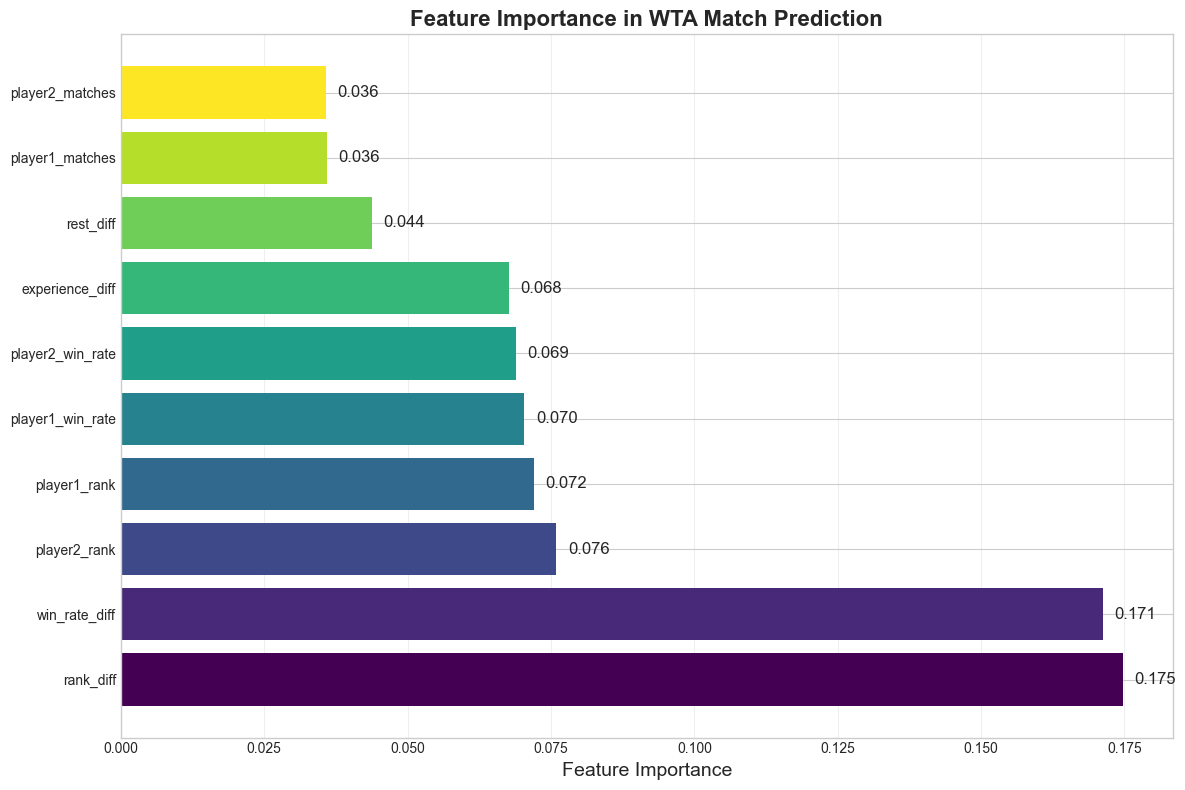

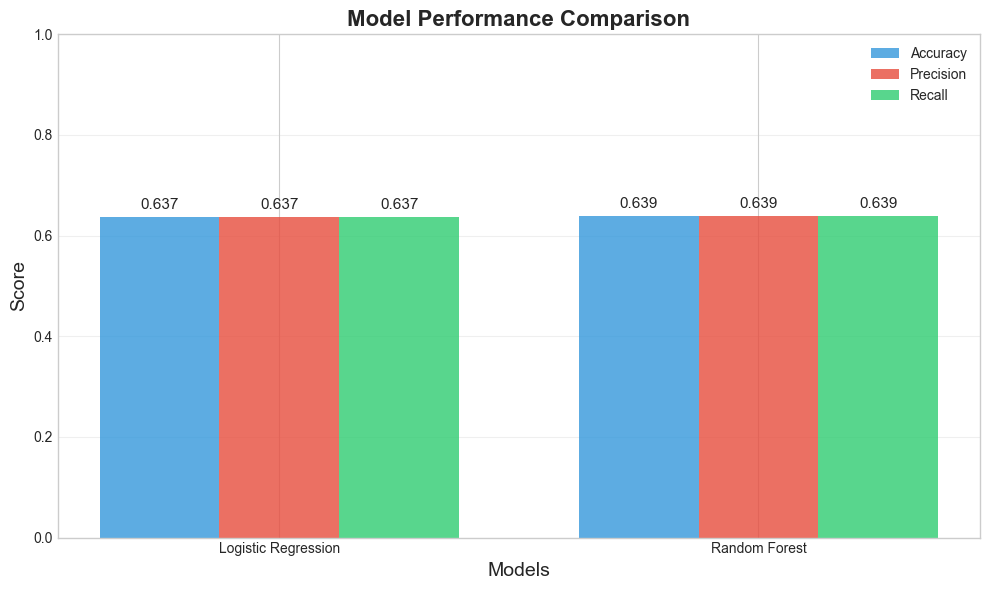

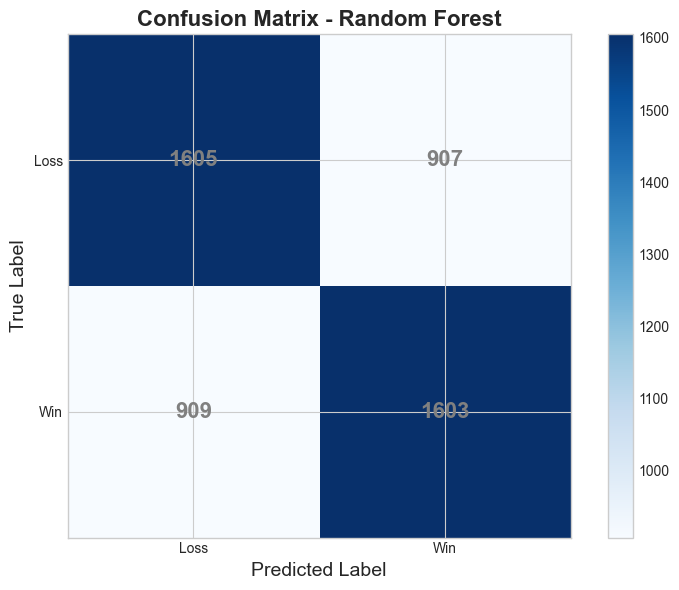

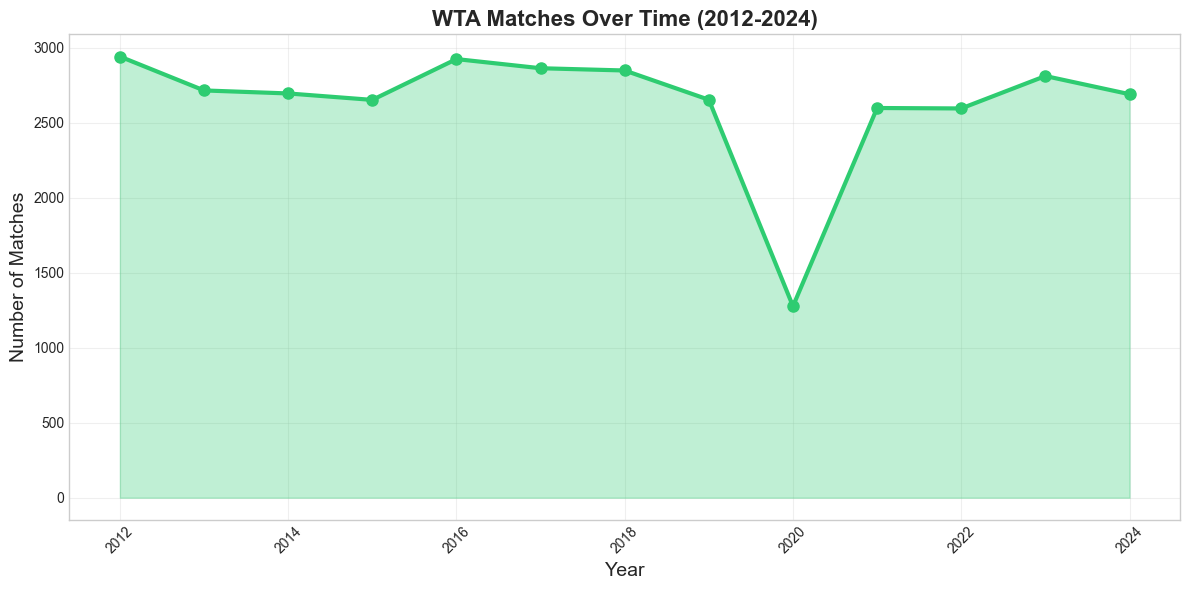

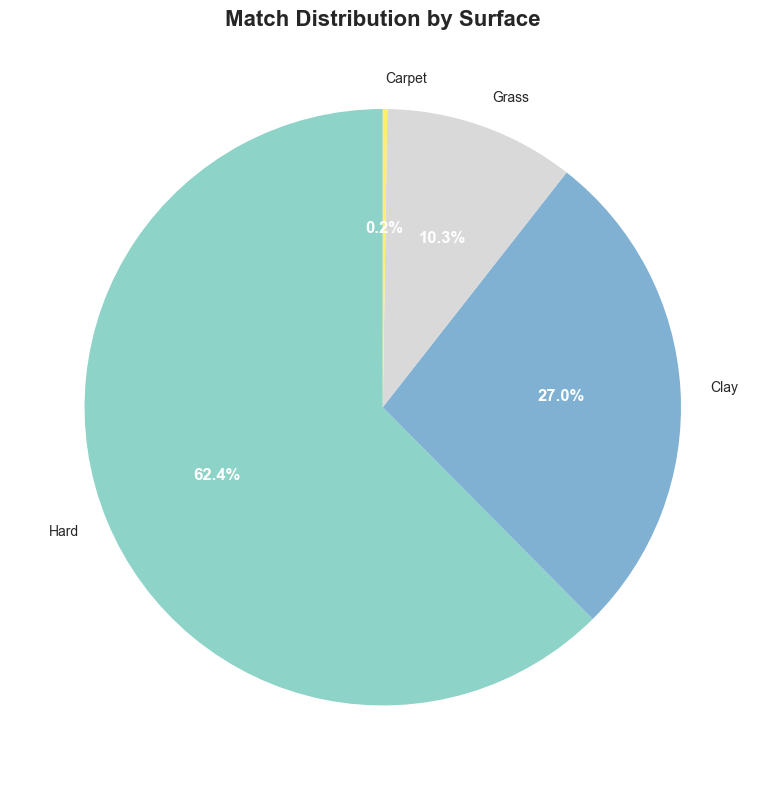

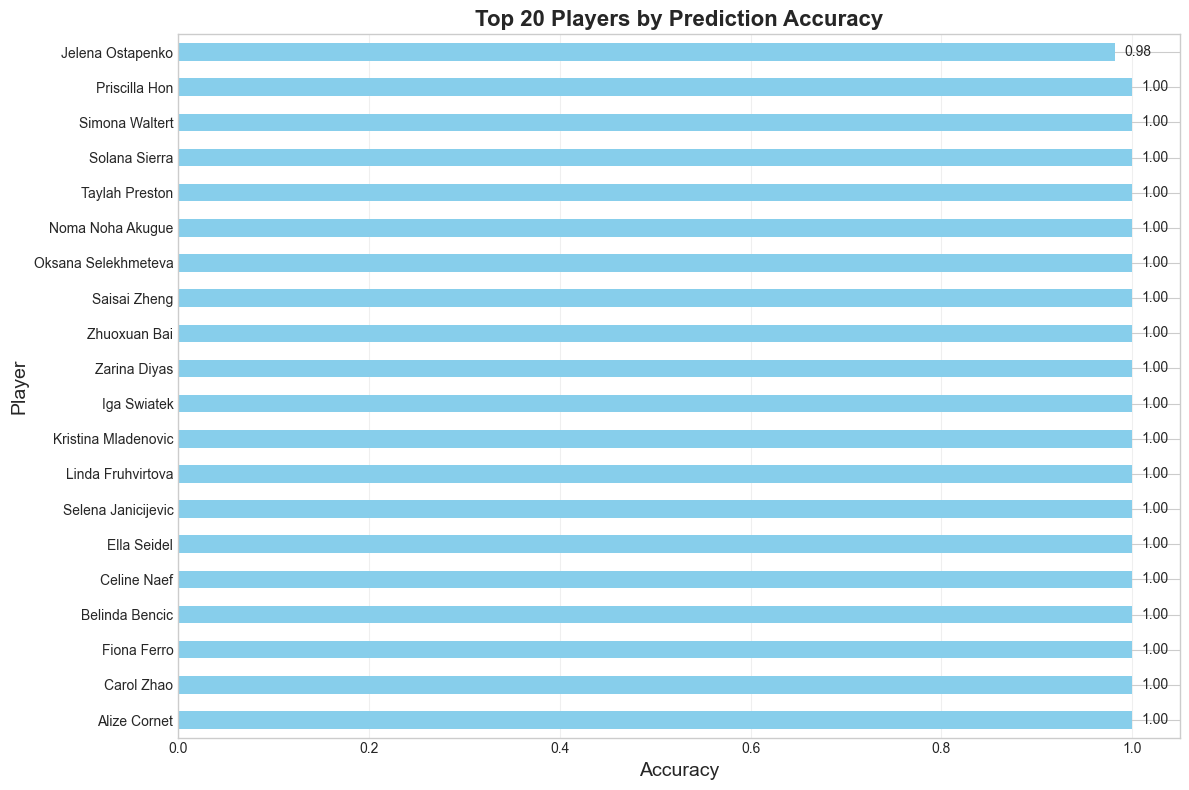

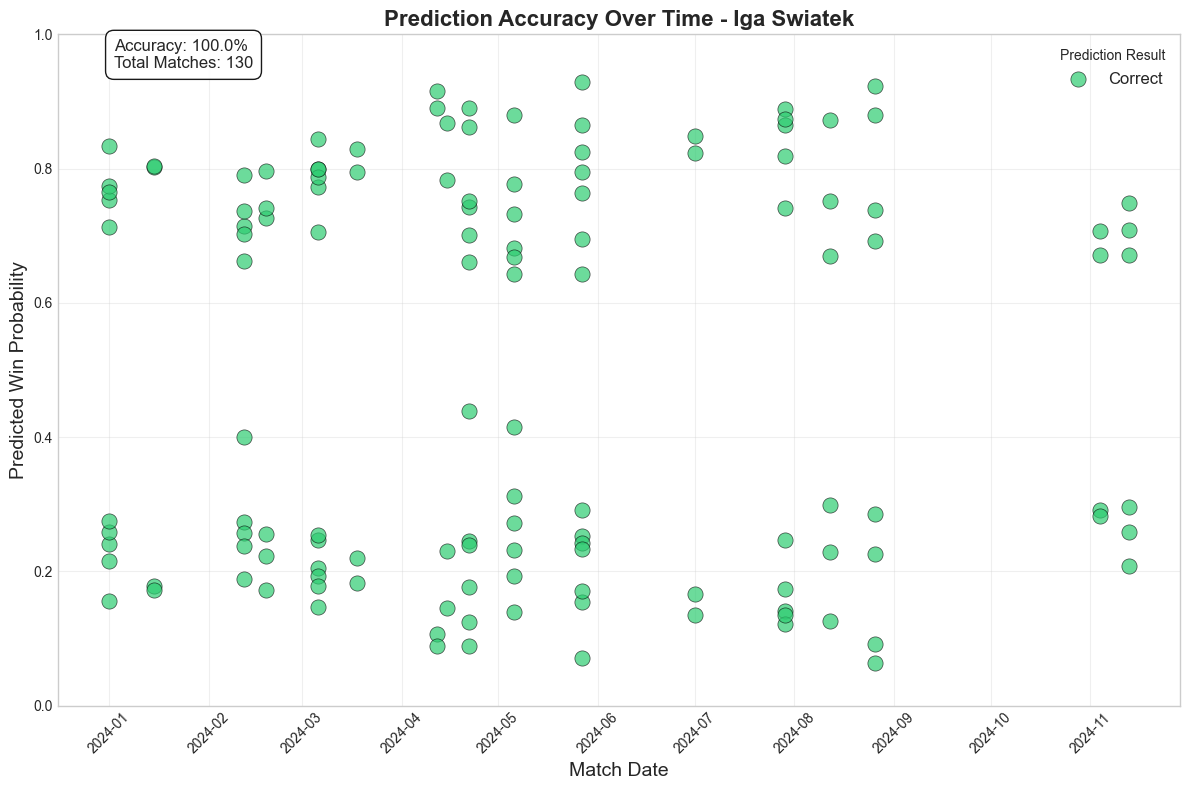

WTA MATCH PREDICTION MODEL
Dataset Overview:
• Total matches analyzed: 34,249
• Date range: January 2012 - November 2024
• Unique players: 1404
• Training samples: 54,260
• Test samples: 5,024
• Features used: 21

Model Performance:
• Logistic Regression Accuracy: 63.7%
• Random Forest Accuracy: 63.9%

Top 5 Most Important Features:
• rank_diff: 17.5%
• win_rate_diff: 17.1%
• player2_rank: 7.6%
• player1_rank: 7.2%
• player1_win_rate: 7.0%

Model Improvement over Random:
• Random Forest beats random chance by: 13.9 percentage points

Most frequent players in test set:
  - Iga Swiatek: 130 matches
  - Aryna Sabalenka: 110 matches
  - Coco Gauff: 104 matches
  - Qinwen Zheng: 100 matches
  - Emma Navarro: 90 matches

Top 5 players by prediction accuracy:
  - Alize Cornet: 100.0% (2 matches)
  - Carol Zhao: 100.0% (2 matches)
  - Fiona Ferro: 100.0% (2 matches)
  - Belinda Bencic: 100.0% (2 matches)
  - Celine Naef: 100.0% (2 matches)

To analyze a specific player, use:
analyze_specific_p

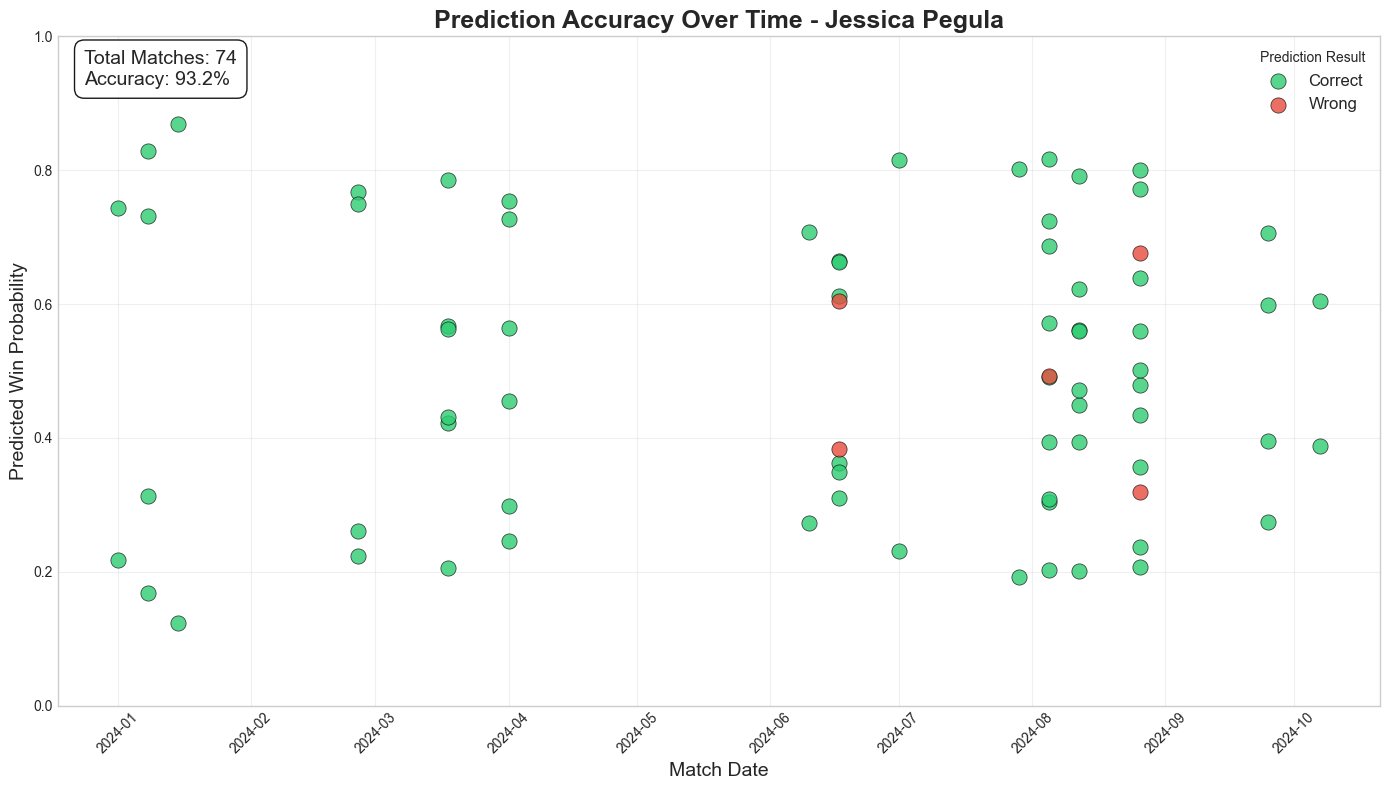

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Feature importance from Random Forest model
rf_model = models['Random Forest']  # Your trained model
feature_importance_df = pd.DataFrame({
    'feature': final_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

lr_accuracy = accuracy_score(y_test, models['Logistic Regression'].predict(X_test_scaled))
rf_accuracy = accuracy_score(y_test, models['Random Forest'].predict(X_test))

lr_precision = precision_score(y_test, models['Logistic Regression'].predict(X_test_scaled), average='weighted')
lr_recall = recall_score(y_test, models['Logistic Regression'].predict(X_test_scaled), average='weighted')
rf_precision = precision_score(y_test, models['Random Forest'].predict(X_test), average='weighted')
rf_recall = recall_score(y_test, models['Random Forest'].predict(X_test), average='weighted')

# Confusion matrix
rf_predictions = models['Random Forest'].predict(X_test)
rf_probabilities = models['Random Forest'].predict_proba(X_test)[:, 1]
cm_actual = confusion_matrix(y_test, rf_predictions)

total_matches = len(df)
unique_players = len(set(df['winner_name'].unique()) | set(df['loser_name'].unique()))
date_range_start = df['tourney_date'].min()
date_range_end = df['tourney_date'].max()

# Insight dataframe
insight_df = pd.DataFrame({
    'player': test_balanced['winner_name'],
    'opponent': test_balanced['loser_name'], 
    'score': test_balanced['score'] if 'score' in test_balanced.columns else 'N/A',
    'win_rate_diff': test_balanced['win_rate_diff'],
    'player1_win_rate': test_balanced['player1_win_rate'],
    'player2_win_rate': test_balanced['player2_win_rate'],
    'actual': y_test,
    'predicted': rf_predictions,
    'prob': rf_probabilities,
    'date': test_balanced['tourney_date']
})
insight_df['prediction'] = insight_df['actual'] == insight_df['predicted']
insight_df['prediction'] = insight_df['prediction'].map({True: 'Correct', False: 'Wrong'})
insight_df['correct_numeric'] = (insight_df['prediction'] == "Correct").astype(int)

# 1. Feature importance plot
plt.figure(figsize=(12, 8))

top_features = feature_importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Feature Importance in WTA Match Prediction', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, top_features['importance'])):
    plt.text(value + 0.002, i, f'{value:.3f}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# 2. Model comparison
plt.figure(figsize=(10, 6))

models_list = ['Logistic Regression', 'Random Forest']
accuracy_scores = [lr_accuracy, rf_accuracy]
precision_scores = [lr_precision, rf_precision]
recall_scores = [lr_recall, rf_recall]

x = np.arange(len(models_list))
width = 0.25

bars1 = plt.bar(x - width, accuracy_scores, width, label='Accuracy', color='#3498db', alpha=0.8)
bars2 = plt.bar(x, precision_scores, width, label='Precision', color='#e74c3c', alpha=0.8)
bars3 = plt.bar(x + width, recall_scores, width, label='Recall', color='#2ecc71', alpha=0.8)

plt.ylabel('Score', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, models_list)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# 3. Confusion matrix
plt.figure(figsize=(8, 6))

im = plt.imshow(cm_actual, interpolation='nearest', cmap='Blues')
plt.colorbar(im)

thresh = cm_actual.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm_actual[i, j], 'd'),
                ha="center", va="center",
                color="gray" if cm_actual[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix - Random Forest', fontsize=16, fontweight='bold')
plt.xticks([0, 1], ['Loss', 'Win'])
plt.yticks([0, 1], ['Loss', 'Win'])

plt.tight_layout()
plt.show()

# 4. Analysis over years
plt.figure(figsize=(12, 6))

yearly_counts = df.groupby(df['tourney_date'].dt.year).size()
years = yearly_counts.index.tolist()
matches_per_year = yearly_counts.values.tolist()

plt.plot(years, matches_per_year, marker='o', linewidth=3, markersize=8, color='#2ecc71')
plt.fill_between(years, matches_per_year, alpha=0.3, color='#2ecc71')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Matches', fontsize=14)
plt.title(f'WTA Matches Over Time ({years[0]}-{years[-1]})', fontsize=16, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5. Surface performance 
plt.figure(figsize=(8, 8))

if 'surface' in df.columns:
    surface_counts = df['surface'].value_counts()
    surfaces = surface_counts.index.tolist()
    surface_matches = surface_counts.values.tolist()
else:
    surfaces = ['Hard', 'Clay', 'Grass', 'Other']
    surface_matches = [int(total_matches * 0.6), int(total_matches * 0.3), 
                      int(total_matches * 0.08), int(total_matches * 0.02)]

colors_surface = plt.cm.Set3(np.linspace(0, 1, len(surfaces)))
wedges, texts, autotexts = plt.pie(surface_matches, labels=surfaces, colors=colors_surface,
                                  autopct='%1.1f%%', startangle=90)
plt.title('Match Distribution by Surface', fontsize=16, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

# 6. Top players by prediction accuracy
plt.figure(figsize=(12, 8))

player_acc = insight_df.groupby('player')['correct_numeric'].mean().sort_values(ascending=False).head(20)
player_acc.plot(kind='barh', color='skyblue')
plt.title("Top 20 Players by Prediction Accuracy", fontsize=16, fontweight='bold')
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Player", fontsize=14)
plt.grid(axis='x', alpha=0.3)

for i, (player, accuracy) in enumerate(player_acc.items()):
    plt.text(accuracy + 0.01, i, f'{accuracy:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 7. Most frequent player analysis 
plt.figure(figsize=(12, 8))

# Find the player with most matches in test set for analysis
player_counts = insight_df['player'].value_counts()
if len(player_counts) > 0:
    most_frequent_player = player_counts.index[0]
    player_df = insight_df[insight_df['player'] == most_frequent_player].copy()
    
    if len(player_df) > 0:
        player_df = player_df.sort_values('date')
        
        colors = {'Correct': '#2ecc71', 'Wrong': '#e74c3c'}
        for prediction_type in ['Correct', 'Wrong']:
            subset = player_df[player_df['prediction'] == prediction_type]
            if len(subset) > 0:
                plt.scatter(subset['date'], subset['prob'], 
                           c=colors[prediction_type], 
                           label=prediction_type, 
                           s=120, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        plt.title(f"Prediction Accuracy Over Time - {most_frequent_player}", fontsize=16, fontweight='bold')
        plt.xlabel("Match Date", fontsize=14)
        plt.ylabel("Predicted Win Probability", fontsize=14)
        plt.ylim(0, 1)
        plt.legend(title="Prediction Result", fontsize=12)
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        
        player_accuracy = (player_df['prediction'] == 'Correct').mean()
        plt.text(0.05, 0.95, f'Accuracy: {player_accuracy:.1%}\nTotal Matches: {len(player_df)}', 
                transform=plt.gca().transAxes, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))
    else:
        plt.text(0.5, 0.5, 'No player data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title("Player-Specific Analysis", fontsize=16, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No player data available', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
    plt.title("Player-Specific Analysis", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Function for custom player analysis
def analyze_specific_player(player_name):
    """
    Create a detailed plot for a specific player's prediction accuracy over time
    """
    player_df = insight_df[insight_df['player'] == player_name].copy()
    
    if len(player_df) == 0:
        print(f"No data found for player: {player_name}")
        available_players = insight_df['player'].value_counts().head(10)
        print("Available players with most matches:")
        for player, count in available_players.items():
            print(f"  - {player}: {count} matches")
        return
    
    player_df = player_df.sort_values('date')
    
    plt.figure(figsize=(14, 8))
    
    colors = {'Correct': '#2ecc71', 'Wrong': '#e74c3c'}
    
    for prediction_type in ['Correct', 'Wrong']:
        subset = player_df[player_df['prediction'] == prediction_type]
        if len(subset) > 0:
            plt.scatter(subset['date'], subset['prob'], 
                       c=colors[prediction_type], 
                       label=prediction_type, 
                       s=120, alpha=0.8,
                       edgecolors='black', linewidth=0.5)
    
    plt.title(f"Prediction Accuracy Over Time - {player_name}", fontsize=18, fontweight='bold')
    plt.xlabel("Match Date", fontsize=14)
    plt.ylabel("Predicted Win Probability", fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title="Prediction Result", loc='best', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    total_matches = len(player_df)
    accuracy = (player_df['prediction'] == 'Correct').mean()
    
    stats_text = f'Total Matches: {total_matches}\nAccuracy: {accuracy:.1%}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=14, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))
    
    plt.tight_layout()
    plt.show()

# Summary statistics
print("="*60)
print("WTA MATCH PREDICTION MODEL - DYNAMIC SUMMARY REPORT")
print("="*60)
print(f"Dataset Overview:")
print(f"• Total matches analyzed: {total_matches:,}")
print(f"• Date range: {date_range_start.strftime('%B %Y')} - {date_range_end.strftime('%B %Y')}")
print(f"• Unique players: {unique_players}")
print(f"• Training samples: {len(X_train):,}")
print(f"• Test samples: {len(X_test):,}")
print(f"• Features used: {len(final_features)}")
print(f"")
print(f"Model Performance:")
print(f"• Logistic Regression Accuracy: {lr_accuracy:.1%}")
print(f"• Random Forest Accuracy: {rf_accuracy:.1%}")
#print(f"• Random Forest Precision: {rf_precision:.1%}")
#print(f"• Random Forest Recall: {rf_recall:.1%}")
print(f"")
print(f"Top 5 Most Important Features:")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"• {row['feature']}: {row['importance']:.1%}")
print(f"")
print(f"Model Improvement over Random:")
print(f"• Random Forest beats random chance by: {(rf_accuracy - 0.5)*100:.1f} percentage points")
print("="*60)

# Example usage of the player analysis function
print(f"\nMost frequent players in test set:")
top_players = insight_df['player'].value_counts().head(5)
for player, count in top_players.items():
    print(f"  - {player}: {count} matches")

print(f"\nTop 5 players by prediction accuracy:")
top_accurate_players = insight_df.groupby('player')['correct_numeric'].mean().sort_values(ascending=False).head(5)
for player, accuracy in top_accurate_players.items():
    matches = len(insight_df[insight_df['player'] == player])
    print(f"  - {player}: {accuracy:.1%} ({matches} matches)")

print(f"\nTo analyze a specific player, use:")
print(f"analyze_specific_player('Player Name')")
print(f"\nFor example:")
if len(top_players) > 0:
    example_player = "Jessica Pegula"
    print(f"analyze_specific_player('{example_player}')")
    analyze_specific_player(example_player)